## Section one: importing necessary packages and functions

In [1]:
import pandas as pd    
import geopandas as gpd
from geopandas.tools import geocode
#import geoplot
from shapely.geometry import Point
import numpy as np
import scipy.stats as stats
import scipy
import shapely
from shapely import speedups
speedups.enabled
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

In [2]:
import urllib.request as request

In [3]:
url_list = ['https://opendata.arcgis.com/datasets/7015d5d46a284f94ac05c2ea4358bcd7_0.geojson',
            'https://opendata.arcgis.com/datasets/5fc63b2a48474100b560a7d98b5097d7_1.geojson',
            'https://opendata.arcgis.com/datasets/27af9a2485c5442bb061fa7e881d7022_2.geojson',
            'https://opendata.arcgis.com/datasets/4f62515558174f53979b3be0335004d3_3.geojson',
            'https://opendata.arcgis.com/datasets/29f801d03c9b4b608bca6a8e497278c3_4.geojson',
            'https://opendata.arcgis.com/datasets/a0019dd0d6464747a88921f5e103d509_5.geojson',
            'https://opendata.arcgis.com/datasets/40bcfbc4054549ebba8b5777bbdd40ff_6.geojson',
            'https://opendata.arcgis.com/datasets/16cedd233d914118a275c6510115d466_7.geojson',
            'https://opendata.arcgis.com/datasets/902fd604ecf54adf8579894508cacc68_8.geojson',
            'https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson',
            'https://opendata.arcgis.com/datasets/2c37babc94d64bbb938a9b520bc5538c_10.geojson',
            'https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.geojson']
    

In [4]:
url = 'https://opendata.arcgis.com/datasets/de58dc3e1efc49b782ab357e044ea20c_9.geojson'
census_bounds = gpd.read_file(url)

In [62]:
def get_gdf(year):
    '''Enter the desired year to download the traffic flow count
    data for that year. Example: enter '7' for the year 2007.
    '''
    num = year-7
    gdf_year = gpd.read_file(url_list[num])
    if year == 11:
        gdf_year = gdf_year.rename(columns={"YEAR_" : 'YEAR'})
    if year == 12:
        gdf_year = gdf_year.rename(columns={'STDY_YEAR' : 'YEAR'})
    if year == 15 or year == 16:
        gdf_year = gdf_year.rename(columns={"COUNTAAWDT" : 'AAWDT', "FLOWSEGID" : "GEOBASID", 'FIRST_STNAME_ORD' : 'STNAME'})
        gdf_year = gdf_year[['AAWDT', 'GEOBASID', 'STNAME', 'SHAPE_Length', 'geometry']]
        if year == 15:
            year_list = ['2015']*len(gdf_year)
            gdf_year['YEAR'] = year_list
        elif year == 16:
            year_list = ['2016']*len(gdf_year)
            gdf_year['YEAR'] = year_list
    elif year == 17 or year == 18:
        gdf_year = gdf_year.rename(columns={"AWDT" : 'AAWDT', "FLOWSEGID" : "GEOBASID", 'STNAME_ORD' : 'STNAME'})
        gdf_year = gdf_year[['AAWDT', 'GEOBASID', 'STNAME', 'SHAPE_Length', 'geometry']]
        if year == 17:
            year_list = ['2017']*len(gdf_year)
            gdf_year['YEAR'] = year_list
        elif year == 18:
            year_list = ['2016']*len(gdf_year)
            gdf_year['YEAR'] = year_list
    #df_year_AAWDT = df_year['AAWDT'].values
    #df_year_geobase = df_year['GEOBASID'].values
    #df_year_dist = df_year['SHAPE_Length'].values
    gdf_year = gdf_year[[ 'YEAR', 'AAWDT', 'GEOBASID', 'STNAME', 'SHAPE_Length', 'geometry']]
    return gdf_year #, df_year_AAWDT, df_year_geobase, df_year_dist

In [149]:
gdf_15 = get_gdf(15)

## Section two: segmenting street data by census tract

### 2a: adding census tract info to street info

This first example is the simplest way to select a specific tract from the census bounds. Note at this point we are only using the census data and not the street data. For the example I've selected the tract where the University is located.

In [196]:
# Creates area dataframe comprised of several tracts
tracts = np.arange(1,5,1)
tracts = list(map(str, tracts))

area = gpd.GeoDataFrame()

for i in range(len(tracts)):
    filter = census_bounds['NAME10'] == tracts[i]
    selection = census_bounds[filter]
    area = area.append(selection)

In [198]:
point = pd.DataFrame({'Longitude': [-122.3355, -122.3355, -122.3355], 'Latitude': [47.6135, 47.6, 47.57]})

In [199]:
point = gpd.GeoDataFrame(point, geometry=gpd.points_from_xy(point.Longitude, point.Latitude))

The following is just a plot of all of the census tracts in gray with a plot of the selected census tract overlaid in red.

<AxesSubplot:>

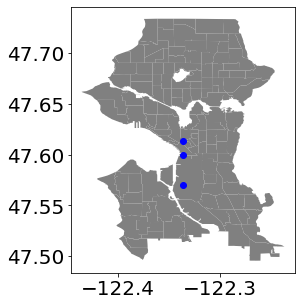

In [200]:
fig, ax = plt.subplots(figsize=(4,8))

census_bounds.plot(ax=ax, facecolor='gray')
#area.plot(ax=ax, facecolor='red')
point.plot(ax=ax, facecolor='blue')

Now we can start to segment the street data by census tract. This first method is best for just individual selections and is probably not the most efficient. You can generate a boolean mask using the census selection and then use it to filter the street data.

In [304]:
Udist_mask = gdf_15.within(area.at[84, 'geometry'])
print(Udist_mask)

KeyError: 84

In [13]:
Udist_data = gdf_15.loc[Udist_mask]
Udist_data.describe()

,AAWDT,GEOBASID,SHAPE_Length
count,30.000000,30.000000,30.000000
mean,14215.277520,1415.233333,536.509590
std,11912.652166,152.400037,553.674731
min,2200.000000,1307.000000,82.251670
25%,4225.000000,1363.250000,247.449472
50%,12145.700974,1388.500000,291.558616
75%,21000.000000,1402.750000,692.835239
max,43594.803000,1961.000000,2966.829559


<AxesSubplot:>

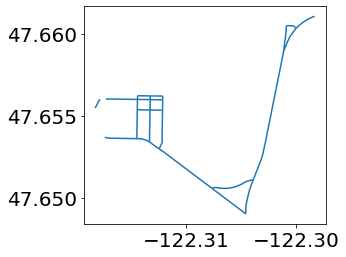

In [14]:
Udist_data.plot()

The better way to do this in my opinion is to join the census data with the street data - then all street data will have its associated census tractk, and you can select specific census tracts by indexing the dataframe. Here is the code to do that:

In [251]:
df_bike = gpd.read_file('Data/Street_Network_Database_SND.geojson')

In [257]:
columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
bike = df_bike[columns]

In [264]:
# Creates list of years in each row
years = []
for i in bike['SNDSEG_UPD'].values:
    years.append(int(i[0:4]))
    #years.append(bike['SNDSEG_UPD'].values[i])

In [266]:
bike['YEAR'] = pd.Series(years)

In [268]:
bike = bike[bike['SEGMENT_TY']==6]

In [317]:
longitudes = []
latitudes = []

for i in bike['geometry'].values:
    
    a = str(i)
    b = a.split('(')[1]
    c = b.split(',')[0]
    longitude = c.split(' ')[0]
    latitude = c.split(' ')[1]
    longitudes.append(longitude)
    latitudes.append(latitude)
    
bike['LONGITUDE'] = pd.Series(longitudes)
bike['LATITUDE'] = pd.Series(latitudes)'''

LINESTRING (-122.3078004896316 47.61410027065467, -122.3074780795867 47.61409946121961)
LINESTRING (-122.2718234585507 47.66127740498662, -122.2712034155422 47.66127570203385, -122.2709190129145 47.66127491991288)
LINESTRING (-122.2944405397592 47.5912551908954, -122.2934229390419 47.59124232848608)
LINESTRING (-122.3527526540051 47.62957774704933, -122.3527512164402 47.6297602940517)
LINESTRING (-122.3644245266698 47.62976375698218, -122.3644224959173 47.630241413982)
LINESTRING (-122.3116231272686 47.58843902264616, -122.3109953591188 47.58843580461986)
LINESTRING (-122.3605340764045 47.62929438882264, -122.3605305719538 47.62958578121552)
LINESTRING (-122.3035056715269 47.63228645388521, -122.3029965360883 47.63228433433029, -122.3022937632486 47.63228614266976)
LINESTRING (-122.3434914746811 47.63341796518926, -122.3429116627482 47.63341977093499)
LINESTRING (-122.2910138818735 47.58942937212849, -122.2909481291744 47.58944140381549, -122.290626230852 47.58943953632801, -122.290473

LINESTRING (-122.3572480527442 47.57011782597857, -122.3574909236269 47.57011858553619)
LINESTRING (-122.3738710134083 47.63595382801011, -122.3738713502532 47.63604181766457, -122.3738720896712 47.6362343822059)
LINESTRING (-122.3098691286469 47.55342805705728, -122.3080278006193 47.55342054122136)
LINESTRING (-122.39480835278 47.56501804802915, -122.394807752559 47.56479109494218)
LINESTRING (-122.367631030142 47.63352751117232, -122.3677884682213 47.63352715682998)
LINESTRING (-122.3725295266093 47.64068388832617, -122.3726332855169 47.64068493258371)
LINESTRING (-122.2914401190353 47.59120175804028, -122.2912570994569 47.59121569000593)
LINESTRING (-122.2915716402253 47.5946220634057, -122.2914573006891 47.59462003866175)
LINESTRING (-122.380171152687 47.5575338935107, -122.3802672600084 47.55745079774495, -122.3807987839088 47.5574551384326)
LINESTRING (-122.2867958670156 47.59909997153757, -122.2866498944151 47.59909256685663)
LINESTRING (-122.3743644147525 47.64068657412135, -12

In [278]:
bike_cleaned = bike.drop(columns=['geometry', 'SNDSEG_UPD', 'SEGMENT_TY'])

In [293]:
bike_cleaned.head()

,SHAPE_Leng,YEAR,LONGITUDE,LATITUDE
3,79.522621,2004,-122.3527526540051,47.62957774704933
33,222.880092,2004,-122.3471568326957,47.63315246940748
157,251.144111,2004,-122.3406878202397,47.63648963625904
241,66.587768,2004,-122.3789935496318,47.55199880857904
266,174.233452,2004,-122.3743644147525,47.64068657412135


In [ ]:
census_bounds.head(1)

In [286]:
columns = ['NAME10', 'SHAPE_Area', 'geometry']
census_bounds_cleaned = census_bounds[columns]

In [303]:
census_bounds_cleaned.head()

,NAME10,SHAPE_Area,geometry
0,25,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."
1,26,1.339838e+07,"POLYGON ((-122.30817 47.69031, -122.30947 47.6..."
2,56,3.212601e+07,"POLYGON ((-122.39300 47.63956, -122.39421 47.6..."
3,68,7.729233e+06,"POLYGON ((-122.35070 47.63994, -122.35130 47.6..."
4,60,1.413816e+07,"POLYGON ((-122.34279 47.64320, -122.34280 47.6..."


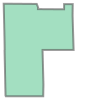

In [311]:
census_bounds_cleaned['geometry'].values[0]

In [316]:
bike_cleaned.tail()

,SHAPE_Leng,YEAR,LONGITUDE,LATITUDE
33598,226.960952,2020,NaN,NaN
33632,342.715121,2019,NaN,NaN
33788,73.788256,2019,NaN,NaN
34106,37.016696,2020,NaN,NaN
34110,38.993437,2020,NaN,NaN


In [314]:
for lon,lat in zip(bike_cleaned.LONGITUDE, bike_cleaned.LATITUDE):
    #pt = Point(lon, lat)
    print(lon)
    print(lat)
#pt

-122.3527526540051
47.62957774704933
-122.3471568326957
47.63315246940748
-122.3406878202397
47.63648963625904
-122.3789935496318
47.55199880857904
-122.3743644147525
47.64068657412135
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

In [308]:
within_census_list = []
for lon,lat in zip(bike_cleaned.LONGITUDE, bike_cleaned.LATITUDE):
    pt = Point(lon, lat)
    within_census = pt.within(census_bounds_cleaned['geometry'].values[0])
    #print( withinQ )
    within_census_list.append(within_census)

# update values in the that column, values: True/False
bike_cleaned['within_census'] = within_census_list

TypeError: must be real number, not str

In [281]:
tracts_by_street = gpd.sjoin(gdf_15, census_bounds, op='within')
tracts_by_street.head(1)

,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length_left,geometry,index_right,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length_right,SHAPE_Area
0,2015,24000.000,2028.0,W SEA BR EB 4 AV OFF RP,1458.971527,"LINESTRING (-122.33092 47.57152, -122.33054 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
9,2015,10000.000,2040.0,S SPOKANE CR ST,74.907110,"LINESTRING (-122.32599 47.57156, -122.32569 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
28,2015,2000.000,2002.0,4TH AV NB ON RP,362.035102,"LINESTRING (-122.32905 47.58934, -122.32926 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
29,2015,7000.000,2003.0,AIRPORT WAY S,480.942822,"LINESTRING (-122.32248 47.59018, -122.32248 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
32,2015,10059.796,2006.0,EAST MARGINAL WAY S,1422.024871,"LINESTRING (-122.33968 47.57170, -122.33969 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08


In [16]:
university_2015 = tracts_by_street.loc[tracts_by_street['NAME10'] == '53.02']

In [17]:
university_2015

,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length_left,geometry,index_right,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length_right,SHAPE_Area
64,2015,21672.120640,1960.0,NE PACIFIC ST,426.892327,"LINESTRING (-122.30597 47.64970, -122.30515 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
65,2015,24000.000000,1961.0,EASTLAKE AVE NE,225.306037,"LINESTRING (-122.31784 47.65602, -122.31797 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
561,2015,43594.803000,1412.0,MONTLAKE BLVD NE,2966.829559,"LINESTRING (-122.30114 47.65898, -122.30207 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
572,2015,31500.000000,1423.0,MONTLAKE BLVD NE,575.275702,"LINESTRING (-122.30001 47.66035, -122.30004 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
573,2015,19500.000000,1424.0,25TH AVE NE,560.713939,"LINESTRING (-122.30114 47.65898, -122.30106 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
574,2015,5500.000000,1425.0,NE 44TH ST,241.814169,"LINESTRING (-122.30091 47.66051, -122.30028 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
575,2015,36000.000000,1428.0,MONTLAKE BLVD NE,495.856467,"LINESTRING (-122.29834 47.66109, -122.29847 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
598,2015,2500.000000,1403.0,NE CAMPUS PKWY,285.005152,"LINESTRING (-122.31326 47.65622, -122.31442 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
612,2015,14000.000000,1363.0,15TH AVE NE,878.010612,"LINESTRING (-122.31246 47.65298, -122.31234 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
613,2015,4000.000000,1364.0,UNIVERSITY WAY NE,712.956092,"LINESTRING (-122.31333 47.65340, -122.31333 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07


<AxesSubplot:>

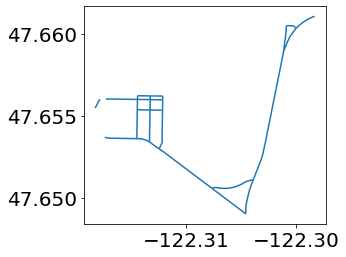

In [18]:
university_2015.plot()

### 2b: Aggregating street info by census tract

Finally, we can aggregate the street info by census tract for better visualization.

In [300]:
#city_by_tract = gpd.sjoin(census_bounds_cleaned, gdf_15, op='intersects')

In [299]:
#city_by_tract.head()

In [294]:
#sarahs_house = city_by_tract.loc[city_by_tract['NAME10'] == '51']

In [295]:
#sarahs_house.head()

In [296]:
#sarahs_house.plot()

In [297]:
#test = sarahs_house['AAWDT'].sum()

In [42]:
#traffic_zones = city_by_tract.dissolve(by='NAME10', aggfunc = sum)

In [43]:
#traffic_zones.reset_index(inplace = True)

In [298]:
#traffic_zones.head()

In [45]:
traffic_zones = traffic_zones[['NAME10','geometry', 'AAWDT' ]]

In [46]:
traffic_zones.head()

,NAME10,geometry,AAWDT
0,1,"POLYGON ((-122.29654 47.73198, -122.29653 47.7...",200687.184322
1,10,"POLYGON ((-122.30218 47.70163, -122.30191 47.7...",190009.612137
2,100.01,"POLYGON ((-122.31733 47.56350, -122.31728 47.5...",356718.912824
3,100.02,"POLYGON ((-122.31607 47.58094, -122.31606 47.5...",262826.787822
4,101,"POLYGON ((-122.29690 47.56783, -122.29690 47.5...",176011.905119


In [47]:
traffic_zones['NAME10'].value_counts()

10       1
76       1
118      1
8        1
87       1
        ..
103      1
43.02    1
71       1
88       1
92       1
Name: NAME10, Length: 134, dtype: int64

In [48]:
test_frame = traffic_zones[traffic_zones['NAME10'] == '51']

In [49]:
test_frame['AAWDT'] == test

77    True
Name: AAWDT, dtype: bool

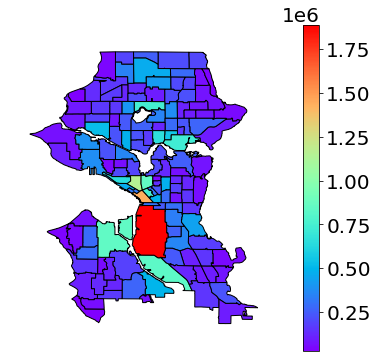

In [50]:
ave_traffic = traffic_zones['AAWDT']
#scheme = mapclassify.NaturalBreaks(ave_traffic, k=10)
geoplot.choropleth(traffic_zones, hue=ave_traffic, cmap='rainbow', legend = True)
plt.show()